In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const
import matplotlib as mpl
from jupyterthemes import jtplot #These two lines can be skipped if you are not using jupyter themes
jtplot.reset()

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.4, Om0=0.314)
import scipy as sp
import multiprocessing as mp


import time
start_total = time.time()

In [2]:
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver

In [3]:
zl = 0.2; zs = 1.2
Dl = cosmo.angular_diameter_distance(zl)   
Ds = cosmo.angular_diameter_distance(zs)    
Dls = cosmo.angular_diameter_distance_z1z2(zl, zs)
G = const.G
rho_crit = (cosmo.critical_density(zl)).to(u.kg/u.m**3)
c_light = (const.c).to(u.cm/u.second)

#r0 = 10*u.kpc
r0 = 10.0*u.kpc
#r0 = 0.1*u.kpc
pi = np.pi

def scale_radius(v,Dl,Ds,Dls):                               #this is e0 in eq 3.42 meneghetti, eq 1 barnacka 2014
    return (4.*pi*v**2/c_light**2*Dl*Dls/Ds).decompose()
def theta_E_SIS():
    'in arcsec'
    pre_theta_E = (scale_radius(v,Dl,Ds,Dls)/Dl).decompose()
    return pre_theta_E*u.rad.to('arcsec', equivalencies=u.dimensionless_angles()) 

v = 180 *u.km/u.s
ss_r = scale_radius(v,Dl,Ds,Dls) 
print('scale radius (m): ',ss_r)
print('scale radius (kpc): ',ss_r.to(u.kpc))
print('theta_E: ',theta_E_SIS() ,'arcsec')
theta_E_num = theta_E_SIS()
elipt = 0.3
re = (const.e.esu**2/const.m_e/(c_light**2)).decompose()
print('Classic electron radius: ',re)

scale radius (m):  7.705329461274929e+19 m
scale radius (kpc):  2.49712721364453 kpc
theta_E:  0.7301786792241515 arcsec
Classic electron radius:  2.817940324670788e-15 m


In [4]:
nu = 130.0 * u.MHz
omega = nu*(1.+zl)*2*np.pi

In [5]:
z0 = 1.*u.kpc
#n0 = 40./(u.cm)**(3)
n0 = 300./(u.cm)**(3)

In [6]:
theta_0 = (r0/Dl).decompose()*u.rad.to('arcsec', equivalencies=u.dimensionless_angles()) 
print('Angular scale radius (theta_0 = r0/Dl): ',theta_0, 'arcsec')

Angular scale radius (theta_0 = r0/Dl):  2.9240748137875747 arcsec


In [7]:
# jet source

radius_3 = 0.5551103128497743

n = 200
t = np.linspace(0,1.3*radius_3*np.sqrt(2)/2,n)
t2 = np.linspace(0,1.3*1.11*radius_3*np.sqrt(2)/2,n)
a = 1.0
b = 0.9

x0 = -0.2*radius_3
y0 = -0.185*radius_3

x1 = 0.01*radius_3
y1 = 0.01*radius_3
x_source_1 = t + x0
y_source_1 = a*t + y0
x_source_2 = t2 + x0 + x1
y_source_2 = b*t2 + y0 - y1
        
mesh_x = []
mesh_y = []
n1 = 7  #n1 lower implies a higher number of points
for j in range(len(x_source_1)):
    for i in range(int(j/n1)):
        mesh_x.append(x_source_1[j]+j*0.02/n)
        z = np.linspace(y_source_2[j]-j*0.02/n, y_source_1[j]+j*0.02/n,int(j/n1))
        mesh_y.append(z[i])
        
mesh__x = []
mesh__y = []
limit = len(mesh_x) - int(n/n1)
for i in range(61):
    mesh_x[i] = 0.
    mesh_y[i] = 0.
for i in range(len(mesh_x)):
    if np.sqrt(mesh_x[i]**2+mesh_y[i]**2) < np.sqrt(mesh_x[limit]**2+mesh_y[limit]**2) and np.sqrt(mesh_x[i]**2+mesh_y[i]**2)>0.001:
        mesh__x.append(mesh_x[i])
        mesh__y.append(mesh_y[i])
        
mesh_x = mesh__x
mesh_y = mesh__y

k = np.array(mesh_y).argmin()
mesh_x[k] = 0
mesh_y[k] = 0

# fig = plt.figure(figsize=(8,8))
# ax = fig.gca()
# ax.set_xticks(np.arange(-2., 2., 0.02))
# ax.set_yticks(np.arange(-2., 2., 0.02))
# ax.set_xlabel(r'$\eta_{x}$ [arcsec]')
# ax.set_ylabel(r'$\eta_{y}$ [arcsec]')
# plt.scatter(mesh_x,mesh_y, s = .5, marker = 'o')
# plt.gca().set_aspect('equal', adjustable='box')
# plt.grid()
# plt.show()

In [8]:
# count blobes from smaller to bigger
alpha = -(np.pi/4 + 1.5* np.pi/180)

rx_1 = 0.017/2
ry_1 = 5*rx_1
cx_1 = 0.12
cy_1 = 0.11+0.01*radius_3
rx_2 = 0.022/2
ry_2 = 5*rx_1
cx_2 = 0.18 
cy_2 = 0.167+0.01*radius_3
rx_3 = 0.027/2
ry_3 = 5*rx_3
cx_3 = 0.26
cy_3 = 0.245+0.01*radius_3 
rx_4 = 0.045/2
ry_4 = 4*rx_4
cx_4 = 0.37 
cy_4 = 0.35+0.01*radius_3   
mesh_light = []
for i in range(len(mesh_x)):
    if ( (mesh_x[i]-cx_1)*np.cos(alpha) + (mesh_y[i]-cy_1)*np.sin(alpha) )**2/rx_1**2 + \
( (mesh_x[i]-cx_1)*np.sin(alpha) - (mesh_y[i]-cy_1)*np.cos(alpha) )**2/ry_1**2 < 1:
        r = np.sqrt(((mesh_x[i]-cx_1)*np.cos(alpha) + (mesh_y[i]-cy_1)*np.sin(alpha) )**2/rx_1**2 + \
( (mesh_x[i]-cx_1)*np.sin(alpha) - (mesh_y[i]-cy_1)*np.cos(alpha) )**2/ry_1**2)
        light = np.exp(-r**2)
        mesh_light.append(light)
    elif ( (mesh_x[i]-cx_2)*np.cos(alpha) + (mesh_y[i]-cy_2)*np.sin(alpha) )**2/rx_2**2 + \
( (mesh_x[i]-cx_2)*np.sin(alpha) - (mesh_y[i]-cy_2)*np.cos(alpha) )**2/ry_2**2 < 1:
        r = np.sqrt(((mesh_x[i]-cx_2)*np.cos(alpha) + (mesh_y[i]-cy_2)*np.sin(alpha) )**2/rx_2**2 + \
( (mesh_x[i]-cx_2)*np.sin(alpha) - (mesh_y[i]-cy_2)*np.cos(alpha) )**2/ry_2**2)
        light = np.exp(-r**2)
        mesh_light.append(light)
    elif ( (mesh_x[i]-cx_3)*np.cos(alpha) + (mesh_y[i]-cy_3)*np.sin(alpha) )**2/rx_3**2 + \
( (mesh_x[i]-cx_3)*np.sin(alpha) - (mesh_y[i]-cy_3)*np.cos(alpha) )**2/ry_3**2 < 1:
        r = np.sqrt(((mesh_x[i]-cx_3)*np.cos(alpha) + (mesh_y[i]-cy_3)*np.sin(alpha) )**2/rx_3**2 + \
( (mesh_x[i]-cx_3)*np.sin(alpha) - (mesh_y[i]-cy_3)*np.cos(alpha) )**2/ry_3**2)
        light = np.exp(-r**2)
        mesh_light.append(light)
    elif ( (mesh_x[i]-cx_4)*np.cos(alpha) + (mesh_y[i]-cy_4)*np.sin(alpha) )**2/rx_4**2 + \
( (mesh_x[i]-cx_4)*np.sin(alpha) - (mesh_y[i]-cy_4)*np.cos(alpha) )**2/ry_4**2 < 1:
        r = np.sqrt(((mesh_x[i]-cx_4)*np.cos(alpha) + (mesh_y[i]-cy_4)*np.sin(alpha) )**2/rx_4**2 + \
( (mesh_x[i]-cx_4)*np.sin(alpha) - (mesh_y[i]-cy_4)*np.cos(alpha) )**2/ry_4**2)
        light = np.exp(-r**2)
        mesh_light.append(light)    
    else:
        light = 1/np.e
        mesh_light.append(light)

In [9]:
def image_position(source):
    x_s, y_s,light = source
    x_pre, y_pre = lensEquationSolver.image_position_from_source(kwargs_lens=kwargs_lens_list, \
                    sourcePos_x=x_s, sourcePos_y=y_s, min_distance=0.05, search_window=5, \
                    precision_limit=10**(-8), num_iter_max=100,non_linear=True)
    light_pre = []
    for k in range(len(x_pre)):
        light_pre = np.append(light_pre,light)
    return x_pre, y_pre, light_pre

def main(x1,x2,x3):
    start_p = time.time()
    x = x1
    y = x2
    l = x3
    
    with mp.Pool(mp.cpu_count()-1) as pool:
        out = pool.map(image_position, zip(x,y,l))
        
        xx = []; yy = []; ll = []
        for i in range(len(out)):
            x = out[i][0]
            xx.append(x)
            y = out[i][1]
            yy.append(y)
            l = out[i][2]
            ll.append(l)
        xx = np.concatenate(xx, axis=0)
        yy = np.concatenate(yy, axis=0)
        ll = np.concatenate(ll, axis=0)
    end_p = time.time()
    pool.close()
    print('time: ',(end_p-start_p)/60.,' minutes')
        
    return xx, yy, ll

In [10]:
mesh_x = mesh_x - mesh_x[0]
mesh_y = mesh_y - mesh_y[0]

In [11]:
lens_model_list = ['PlasmaExponentialSIE']
lensModel = LensModel(lens_model_list)
lensEquationSolver = LensEquationSolver(lensModel)

In [12]:
A = 2.00744300029693
B = 1.5887225542022732
C = 1.4308204791467736


psi0_plasma = (A*Dls/Ds/Dl*2*pi*c_light**2/omega**2*re*n0*r0 \
            *(u.rad**2).to('arcsec**2', equivalencies=u.dimensionless_angles()) ).decompose()



print('psi0_plasma: ',psi0_plasma)

kwargs = {'theta_E':theta_E_num.value,'eta':0*elipt, 'A':A, 'B':B, 'C':C ,'psi0_plasma':psi0_plasma.value,\
                'theta_0':theta_0.value}

kwargs_lens_list = [kwargs]

psi0_plasma:  0.47012437534577306


In [13]:
lensModelExtensions = LensModelExtensions(lensModel=lensModel)

SSS = lensModelExtensions.critical_curve_caustics(kwargs_lens=kwargs_lens_list, compute_window=5, \
                                                     grid_scale=0.001)

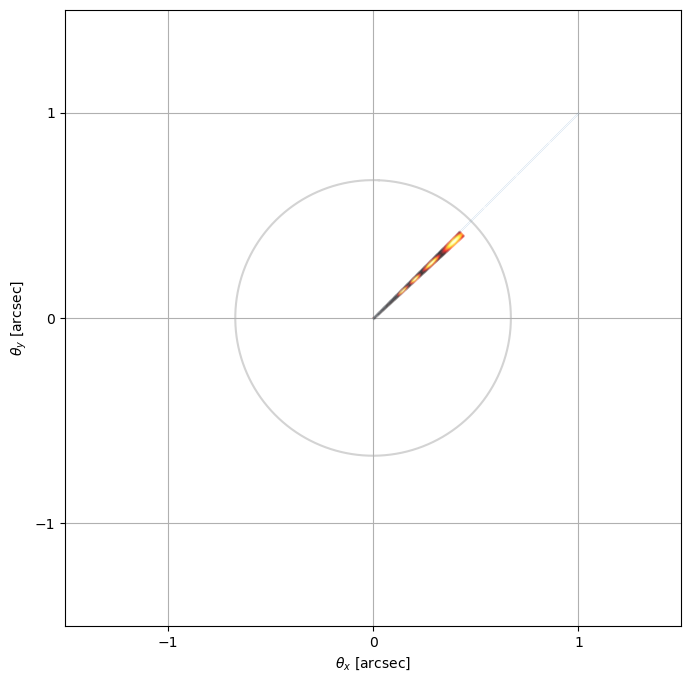

In [50]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 1))
ax.set_yticks(np.arange(-2., 2., 1))


line_x = np.linspace(0,1,200)
plt.scatter(mesh_x,mesh_y, s =.002, c=mesh_light, cmap='hot',zorder = 2)
plt.scatter(line_x,line_x, s =.002,zorder = 2)
plt.plot(SSS[0][0],SSS[1][0], color = '#d3d3d3',zorder=1)
plt.plot(SSS[2][0],SSS[3][0], color = '#ffd1d1',zorder=1)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.gca().set_aspect('equal', adjustable='box')
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
plt.grid()
plt.show()

In [15]:
thetarot = 1.5*np.pi/180
mesh_x_1 = np.array(mesh_x)*np.cos(thetarot) -  np.array(mesh_y)*np.sin(thetarot) 
mesh_y_1 = np.array(mesh_x)*np.sin(thetarot) +  np.array(mesh_y)*np.cos(thetarot) 

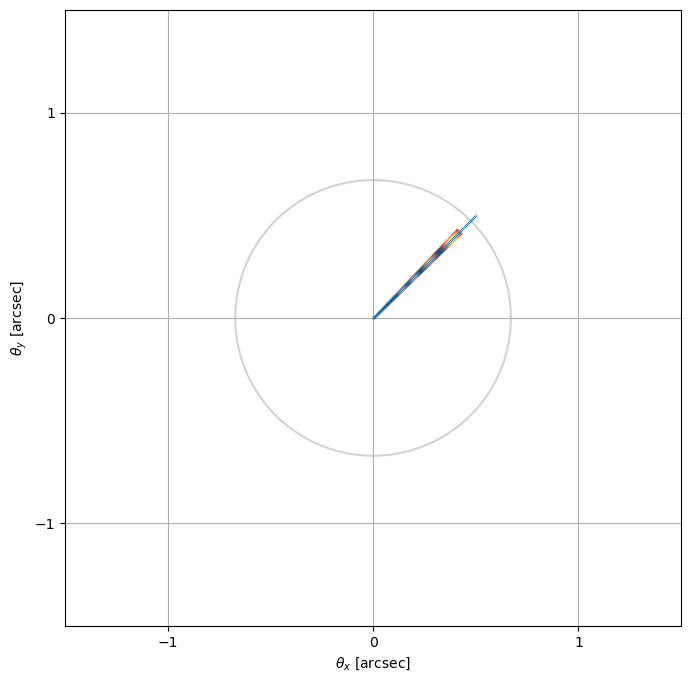

In [16]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 1))
ax.set_yticks(np.arange(-2., 2., 1))


line_x = np.linspace(0,.5,1500)
plt.scatter(mesh_x_1,mesh_y_1, s =.002, c=mesh_light, cmap='hot',zorder = 2)
plt.scatter(line_x,line_x, s =.002,zorder = 2)
plt.plot(SSS[0][0],SSS[1][0], color = '#d3d3d3',zorder=1)
plt.plot(SSS[2][0],SSS[3][0], color = '#ffd1d1',zorder=1)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.gca().set_aspect('equal', adjustable='box')
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
plt.grid()
plt.show()

In [17]:
mesh_x_1_line = []
mesh_y_1_line = []
mesh_light_line = []
for i in range(len(mesh_x_1)):
    a = 0
    for j in range(len(line_x)):
        if np.sqrt( (mesh_x_1[i]-line_x[j])**2 + (mesh_y_1[i]-line_x[j])**2 ) < .00093:
            a = 1
    if a == 1:
        mesh_x_1_line.append(mesh_x_1[i])
        mesh_y_1_line.append(mesh_y_1[i])
        mesh_light_line.append(mesh_light[i])
        

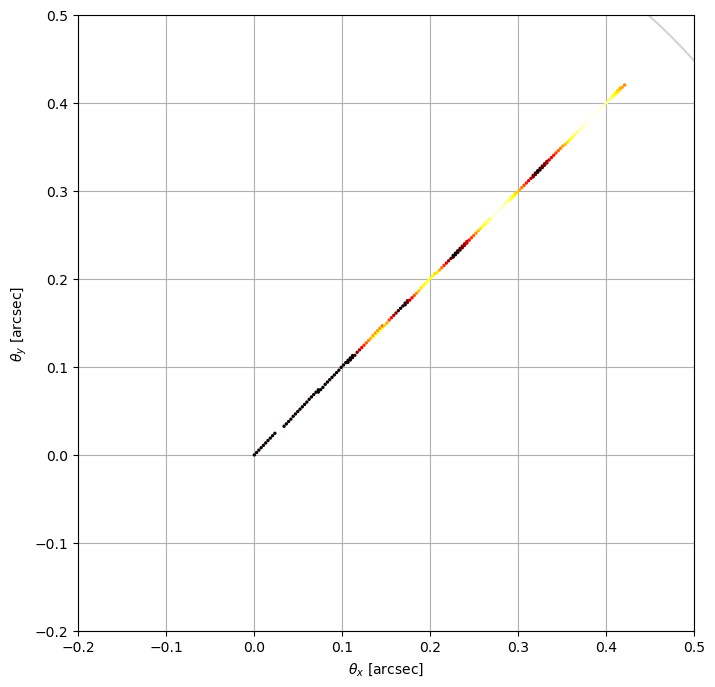

In [18]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-1., 1., .1))
ax.set_yticks(np.arange(-1., 1., .1))


line_x = np.linspace(0,1,200)
plt.scatter(mesh_x_1_line,mesh_y_1_line, s =2, c=mesh_light_line, cmap='hot',zorder = 2)
#plt.scatter(line_x,line_x, s =.002,zorder = 2)
plt.plot(SSS[0][0],SSS[1][0], color = '#d3d3d3',zorder=1)
plt.plot(SSS[2][0],SSS[3][0], color = '#ffd1d1',zorder=1)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.gca().set_aspect('equal', adjustable='box')
ax.set_xlim([-0.2, .5])
ax.set_ylim([-0.2, .5])
plt.grid()
plt.show()

In [19]:
line_indexes = []
for i in range(len(mesh_x_1)):
    for j in range(len(mesh_x_1_line)):
        if mesh_x_1[i] == mesh_x_1_line[j]:
            line_indexes.append(i)

In [20]:
pd = [] #projected distance from core for elements in the line
for i in range(len(mesh_x_1_line)):
    a = np.sqrt(mesh_x_1_line[i]**2 + mesh_y_1_line[i]**2)
    pd.append(a)

In [68]:
x_image_1, y_image_1, light_1 = main(mesh_x_1,mesh_y_1,mesh_light)

time:  0.2891487638155619  minutes


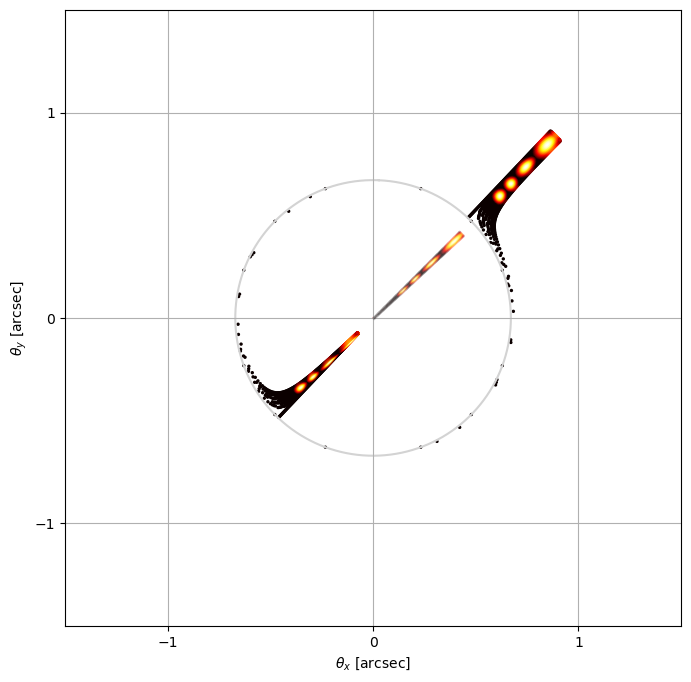

In [69]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 1))
ax.set_yticks(np.arange(-2., 2., 1))

plt.scatter(mesh_x,mesh_y, s =.002, c=mesh_light, cmap='hot',zorder = 2)
#plt.plot(x_circle1,y_circle1,color='#bae4a7',lw = 1.5,zorder=1)
plt.plot(SSS[0][0],SSS[1][0], color = '#d3d3d3',zorder=1)
plt.plot(SSS[2][0],SSS[3][0], color = '#ffd1d1',zorder=1)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(x_image_1, y_image_1, c=light, cmap='hot', s = 2)
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
plt.grid()
plt.show()

In [23]:
thetarot = -np.pi/4. + np.pi/180
mesh_x_2 = np.array(mesh_x_1)*np.cos(thetarot) -  np.array(mesh_y_1)*np.sin(thetarot) - .5
mesh_y_2 = np.array(mesh_x_1)*np.sin(thetarot) +  np.array(mesh_y_1)*np.cos(thetarot) + .4



In [24]:
x_image_2, y_image_2, light_2 = main(mesh_x_2,mesh_y_2,mesh_light)

time:  0.16697848637898763  minutes


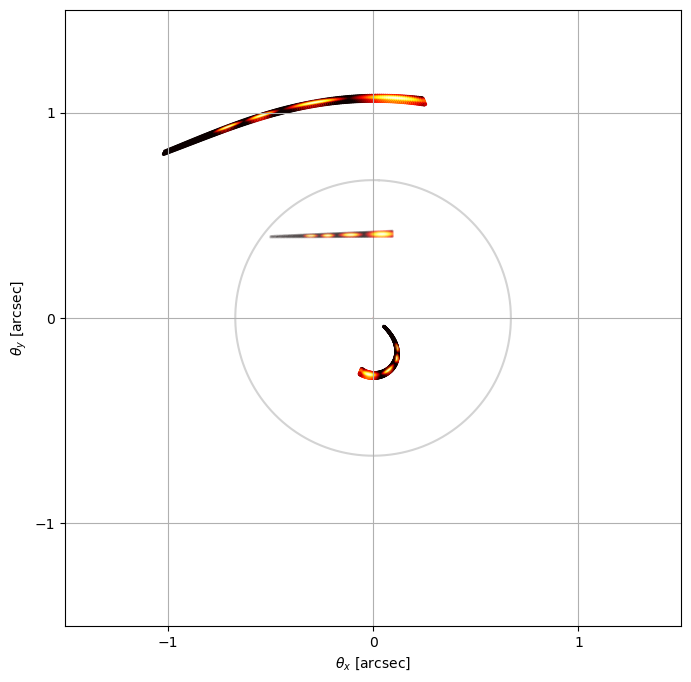

In [25]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 1))
ax.set_yticks(np.arange(-2., 2., 1))

plt.scatter(mesh_x_2,mesh_y_2, s =.002, c=mesh_light, cmap='hot',zorder = 2)
#plt.plot(x_circle1,y_circle1,color='#bae4a7',lw = 1.5,zorder=1)
plt.plot(SSS[0][0],SSS[1][0], color = '#d3d3d3',zorder=1)
plt.plot(SSS[2][0],SSS[3][0], color = '#ffd1d1',zorder=1)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(x_image_2, y_image_2, c=light_2, cmap='hot', s = 2)
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
plt.grid()
plt.show()

In [34]:
thetarot = -np.pi/4. + np.pi/180
mesh_x_3 = np.array(mesh_x_1)*np.cos(thetarot) -  np.array(mesh_y_1)*np.sin(thetarot) - .1
mesh_y_3 = np.array(mesh_x_1)*np.sin(thetarot) +  np.array(mesh_y_1)*np.cos(thetarot) + .6



In [35]:
x_image_3, y_image_3, light_3 = main(mesh_x_3,mesh_y_3,mesh_light)

time:  0.18754031658172607  minutes


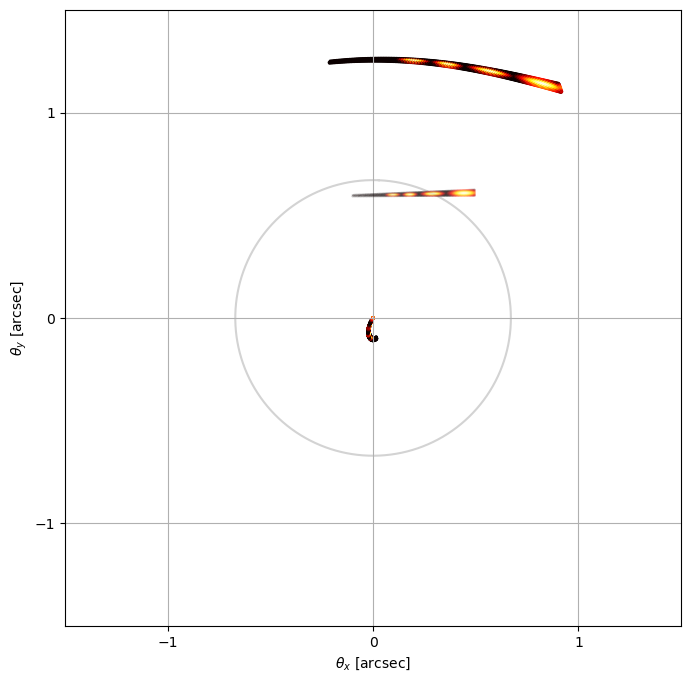

In [36]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 1))
ax.set_yticks(np.arange(-2., 2., 1))

plt.scatter(mesh_x_3,mesh_y_3, s =.002, c=mesh_light, cmap='hot',zorder = 2)
#plt.plot(x_circle1,y_circle1,color='#bae4a7',lw = 1.5,zorder=1)
plt.plot(SSS[0][0],SSS[1][0], color = '#d3d3d3',zorder=1)
plt.plot(SSS[2][0],SSS[3][0], color = '#ffd1d1',zorder=1)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(x_image_3, y_image_3, c=light_3, cmap='hot', s = 2)
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
plt.grid()
plt.show()

In [41]:
thetarot = -np.pi/4. + np.pi/180
mesh_x_4 = np.array(mesh_x_1)*np.cos(thetarot) -  np.array(mesh_y_1)*np.sin(thetarot) - .3
mesh_y_4 = np.array(mesh_x_1)*np.sin(thetarot) +  np.array(mesh_y_1)*np.cos(thetarot) - .2



In [42]:
x_image_4, y_image_4, light_4 = main(mesh_x_4,mesh_y_4,mesh_light)

time:  0.1597046176592509  minutes


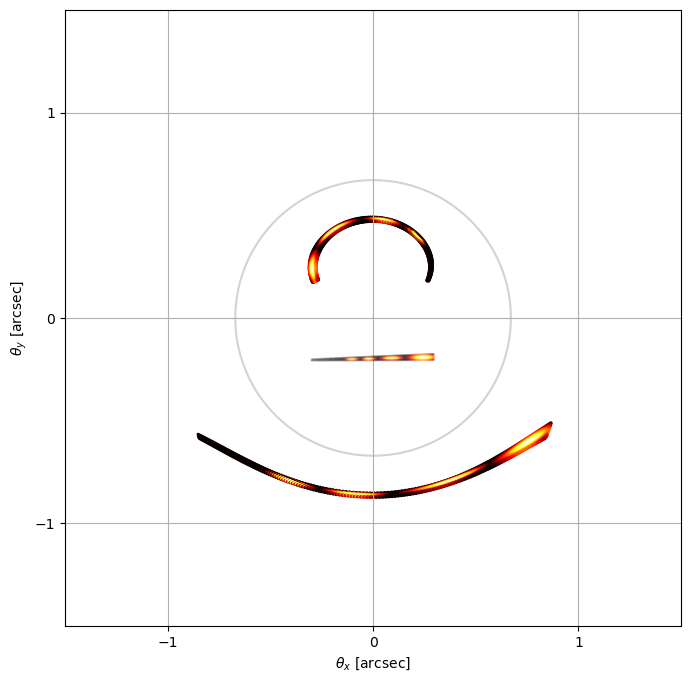

In [43]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 1))
ax.set_yticks(np.arange(-2., 2., 1))

plt.scatter(mesh_x_4,mesh_y_4, s =.002, c=mesh_light, cmap='hot',zorder = 2)
#plt.plot(x_circle1,y_circle1,color='#bae4a7',lw = 1.5,zorder=1)
plt.plot(SSS[0][0],SSS[1][0], color = '#d3d3d3',zorder=1)
plt.plot(SSS[2][0],SSS[3][0], color = '#ffd1d1',zorder=1)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(x_image_4, y_image_4, c=light_4, cmap='hot', s = 2)
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
plt.grid()
plt.show()

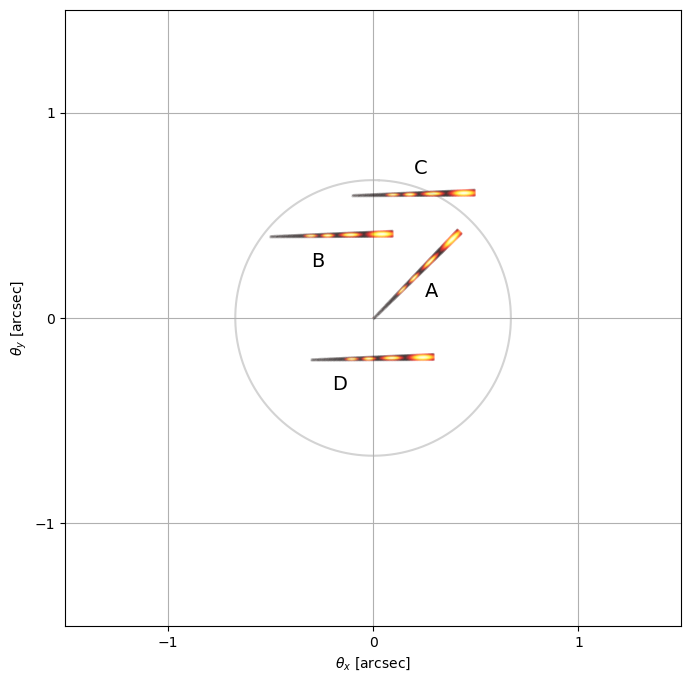

In [67]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 1))
ax.set_yticks(np.arange(-2., 2., 1))



plt.scatter(mesh_x_1,mesh_y_1, s =.002, c=mesh_light, cmap='hot',zorder = 2)
plt.scatter(mesh_x_2,mesh_y_2, s =.002, c=mesh_light, cmap='hot',zorder = 2)
plt.scatter(mesh_x_3,mesh_y_3, s =.002, c=mesh_light, cmap='hot',zorder = 2)
plt.scatter(mesh_x_4,mesh_y_4, s =.002, c=mesh_light, cmap='hot',zorder = 2)
plt.plot(SSS[0][0],SSS[1][0], color = '#d3d3d3',zorder=1)
plt.plot(SSS[2][0],SSS[3][0], color = '#ffd1d1',zorder=1)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.gca().set_aspect('equal', adjustable='box')
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
plt.text(.25,.1,'A', fontsize = 14)
plt.text(-.3,.25,'B', fontsize = 14)
plt.text(.2,.7,'C', fontsize = 14)
plt.text(-.2,-.35,'D', fontsize = 14)
plt.grid()
plt.show()

In [33]:
end_total = time.time()
print('total time: ',(end_total-start_total)/60.,' minutes')


total time:  1.6833677450815836  minutes
